<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<div style="float:right; width:98 px; height:98px;">
<img src="https://media.licdn.com/dms/image/C4E0BAQFlOZSAJABP4w/company-logo_200_200/0/1548285168598?e=2147483647&v=beta&t=g4jl8rEhB7HLJuNZhU6OkJWHW4cul_y9Kj_aoD7p0_Y" alt="STI Logo" style="height: 98px;">
</div>


<h1>Data Regridding with CDO Step 1: Prepare and Run CDO</h1>
By: Kayla Besong, PhD
    <br>
Last Edited: 04/30/24
<br>
<br>    
<br>
The goal of this notebook is to regrid CONUS404, HRRR, NAM, and NARR files by combining python, the terminal, and CDO. It steps you through by testing one file at a time per grid to workout what the input files should be for CDO and then provides information on how to loop through all files. There is some manual work, including figuring out the size of the grids, some cleaning functions, exporting txt files and interacting with the terminal. The most important thing is that all the file paths remain organized! 
<br>
<br>
Once a test file per model is executed, it is plotted over CONUS and subregionally over the Great Lakes to ensure the regridding process has worked. If it did not, you will know. 
<br>
<br>
After successful testing of one file and an example bash script is provided to run in the terminal that loops over all files per model, performing CDO remapbil on all files in a given directory. 
<br>    
<br>
Cleaning for the NARR must take place prior to running the bash script due its 'generic grid'. That process is provided. CDO does not simply accept assigning attributes to an xarray dataset from a file that has metadata to define the grid. The work around is to use a file and manually patch together/add a given variable a to a 'shell' dataset with a non-generic grid. It seems excessive but was found to be the only solution accepted by CDO at the time.
<br>    
<br>
Other, post-CDO cleaning functions are designed for non-NARR models and can be found in Regrid_Check_n_Clean.ipynb. They are designed for random files that failed during CDO. 
<br>    
<br>
If you do not have CDO installed, you can get it here: https://code.mpimet.mpg.de/projects/cdo/. CDO or the Climate Data Operator is a very common and highly trusted tool used by many.
<div style="clear:both"></div>
</div>

<hr style="height:2px;">

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import cartopy.feature as cf

from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator

# generate reference files

In [2]:
model_options = ['CONUS404', 'HRRR', 'NAM', 'NARR']

In [3]:
# model_options = ['NARR']

In [27]:
def special_narr_handler_cdo(t):

    ''' This function assigns grid information to NARR files downloaded through this code repo. For whatever reason,
    the downloaded files did not contain grid information (or it was lost in the processing steps) that is accepted by CDO.
    The bandaid fix/work around is to download a file from the PSL landing page: https://psl.noaa.gov/data/gridded/data.narr.html 
    such as air.sfc.1992.nc and use it as the bones of the xarray dataset. The time dimension is replaced with the input file, 
    the original variable is dropped, and the input dataset is changed to a new dataarray and assigned to the xarray shell. 
    This is by no means a pretty fix, but is better than going through the entire download/cleaning process prior to this step. 
    If this is not run, CDO does not recognize the 'generic grid'. 

    A version to loop over variables is provided below. 

    Inputs:

    t: (xarray dataset) a NARR file opened with xarray in need of grid assignment 

    Outputs:

    narr_grid: (xarray dataset) the input, t, but with grid information accepted by CDO.

    '''

    narr_grid = xr.open_dataset('air.sfc.1992.nc').resample(time = '24H').mean('time') #.isel(time = 70).drop('air')
    narr_grid = narr_grid.isel(time = np.arange(0, len(t.time)))
    narr_grid['time'] = t['time']
    
    t_vals_da = xr.DataArray(t.Temperature_height_above_ground.values, dims=['time', 'y', 'x'], coords={'lat': narr_grid['lat'], 'lon': narr_grid['lon'], 'y': narr_grid['y'], 'x': narr_grid['x'], 'time': narr_grid['time']})

    narr_grid['Temperature_height_above_ground'] = t_vals_da
    
    return narr_grid

In [28]:
model_dict = {}

for m in model_options:
    path = glob.glob(os.path.join(f'model_regridding/example_grids/RAW/', f'*{m}*.nc'))
    print(path)
    if m == 'CONUS404':
        t = xr.open_dataset(path[0]) #.isel(Time = 69)
        x = 'XLAT'
        y = 'XLONG'

    elif m == 'NARR':
        t = xr.open_dataset(path[0]).isel(height_above_ground = 0).drop('height_above_ground')
        t = special_narr_handler_cdo(t)
            
        x = 'x'
        y = 'y'

    else:
        
        t = xr.open_dataset(path[0]) #.isel(time = 69)
        x = 'longitude'
        y = 'latitude'

    model_dict[m] = [t, [x, y]]
    
    #t.to_netcdf(f'model_regridding/example_grids/PROCESSED/{m}_year_example_grid.nc')
    

['model_regridding/example_grids/RAW/T2AVG_CONUS404_ANALYSIS_Daily_2014.nc']


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


['model_regridding/example_grids/RAW/t2mAVG_HRRR_HISTORICAL_Daily_2014.nc']
['model_regridding/example_grids/RAW/t2mAVG_NAM_HISTORICAL_Daily_2014.nc']
['model_regridding/example_grids/RAW/Temperature_height_above_groundAVG_NARR_REANALYSIS_Daily_2014.nc']


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


# Generate target grids

This section requires a bit of manual work and research to correctly define the target grid you want to interpolate to. To get the correct xsize,
you need to take (xmax-xmin)/grid_spacing and similar for y. The following loop helps with those numbers with a bit of back of the napkin work below 
each instance. Goodluck!

In [5]:
for m in model_options:
    sub = model_dict[m][0]
    dims = model_dict[m][1]    
    print(f'{m} -- y_min: {np.min(sub[dims[0]].values)}, ymax = {np.max(sub[dims[0]].values)}, x_min: {np.min(sub[dims[1]].values)}, xmax = {np.max(sub[dims[1]].values)}')


CONUS404 -- y_min: 17.647308349609375, ymax = 57.34341812133789, x_min: -138.73135375976562, xmax = -57.068634033203125
HRRR -- y_min: 225.90387325951775, ymax = 299.08216099364034, x_min: 21.138, xmax = 52.61565399063001
NAM -- y_min: 207.10447050218713, ymax = 310.65536316526163, x_min: 12.190000000000017, xmax = 61.33087815156561
NARR -- y_min: 0.0, ymax = 11297120.0, x_min: 0.0, xmax = 8959788.0


In [ ]:
### CONUS404 Target Grid Description File

data = '''
gridtype  = lonlat
gridsize  = 2392425
xsize     = 2205
ysize     = 1085
xname     = longitude
xlongname = longitude
xunits    = degrees_east
yname     = latitude
ylongname = latitude
yunits    = degrees_north
xfirst    = -137.873
xlast     = -58.463
xinc      = 0.036
yfirst    = 17.631
ylast     = 56.704
yinc      = 0.036
'''

lines = data.strip().split('\n')

with open('model_regridding/CONUS404_target.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')


In [ ]:
### CONUS404 back of the napkin

### x size calc

print((137.873 - 58.463)/0.036)

#### y size calc

print((56.704-17.631)/0.036)

In [ ]:
2205*1085

In [ ]:
### HRRR Target Grid Description File

data = '''
gridtype  = lonlat
gridsize  = 3157150
xsize     = 2710
ysize     = 1165
xname     = longitude
xlongname = longitude
xunits    = degrees_east
yname     = latitude
ylongname = latitude
yunits    = degrees_north
xfirst    = -134.096
xlast     = -60.91719277
xinc      = 0.027
yfirst    = 21.138
ylast     = 52.615
yinc      = 0.027
'''

lines = data.strip().split('\n')

with open('model_regridding/HRRR_target.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')

In [ ]:
### HRRR back of the napkin

### x size calc

print(((134.096 - 60.91719277)/0.027))

#### y size calc

print((52.615-21.138)/0.027)

In [ ]:
2710*1165

In [ ]:
### NAM Target Grid Description File

data = '''
gridtype  = lonlat
gridsize  = 435890
xsize     = 958
ysize     = 455
xname     = longitude
xlongname = longitude
xunits    = degrees_east
yname     = latitude
ylongname = latitude
yunits    = degrees_north
xfirst    = -152.9
xlast     = -49.34
xinc      = 0.108
yfirst    = 12.19
ylast     = 61.33
yinc      = 0.108 
'''

lines = data.strip().split('\n')

with open('model_regridding/NAM_target.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')

In [ ]:
### NAM back of the napkin

### x size calc
print((360-207.10), (360-310.655))

print(((360-207.10) - (360-310.655))/0.108)

#### y size calc

print((61.33-12.19)/0.108)

In [ ]:
455*958

In [55]:
### NARR Target Grid Description File

data = '''
gridtype  = lonlat
gridsize  = 195295
xsize     = 695
ysize     = 281
xname     = longitude
xlongname = longitude
xunits    = degrees_east
yname     = latitude
ylongname = latitude
yunits    = degrees_north
xfirst    = -211.36
xlast     = -2.56592
xinc      = 0.3
yfirst    = 0.8968
ylast     = 85.33401
yinc      = 0.3 
'''

lines = data.strip().split('\n')

with open('model_regridding/NARR_target.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')

In [53]:
## download the NARR grid text and find the min,max lat,lons 
## ftp://ftp.emc.ncep.noaa.gov/mmb/mmbpll/gridlola.eta/latlon.g221

In [11]:
narr_lat_lon = pd.read_csv('../NARR_LatLon.txt', skiprows=5, header=None, names=['lambert-i', 'lambert-j', 'lat(degN)', 'lon(degW)'], delim_whitespace=True)

In [14]:
narr_lat_lon['lon(degW)'].max(), narr_lat_lon['lon(degW)'].min()

(211.36145, 2.56592)

In [17]:
narr_lat_lon['lat(degN)'].max(), narr_lat_lon['lat(degN)'].min()

(85.33401, 0.8968)

In [39]:
((360-2.56592)-148.64)/.3, (85.33401-0.8968)/.3

(695.9802666666667, 281.4573666666667)

In [38]:
360-211.36

148.64

In [40]:
695*281

195295

In [54]:
360-148.64

211.36

# generate copy and paste CDO text to make everything easy to paste into terminal line

In [51]:

for m in model_options:
    print(f'cdo remapbil,{m}_target.txt example_grids/PROCESSED/{m}_year_example_grid.nc output_ex/{m}_year_test_regrid.nc')

cdo remapbil,CONUS404_target.txt example_grids/PROCESSED/CONUS404_year_example_grid.nc output_ex/CONUS404_year_test_regrid.nc
cdo remapbil,HRRR_target.txt example_grids/PROCESSED/HRRR_year_example_grid.nc output_ex/HRRR_year_test_regrid.nc
cdo remapbil,NAM_target.txt example_grids/PROCESSED/NAM_year_example_grid.nc output_ex/NAM_year_test_regrid.nc
cdo remapbil,NARR_target.txt example_grids/PROCESSED/NARR_year_example_grid.nc output_ex/NARR_year_test_regrid.nc


In [56]:
vars[2]

'Time'

# test the regridding process with maps 

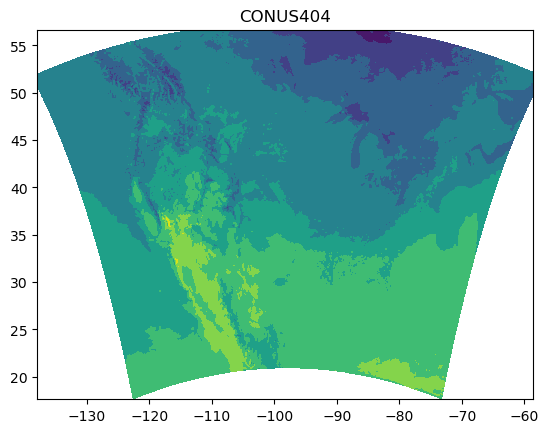

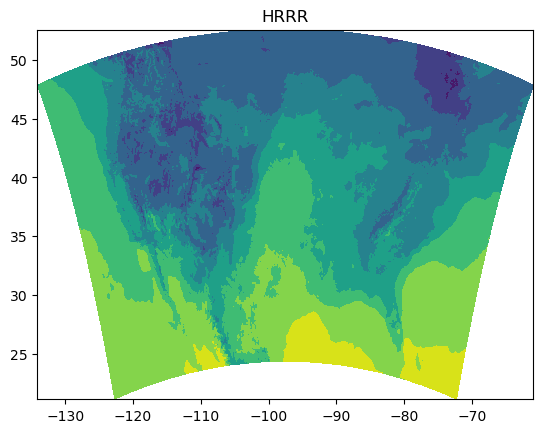

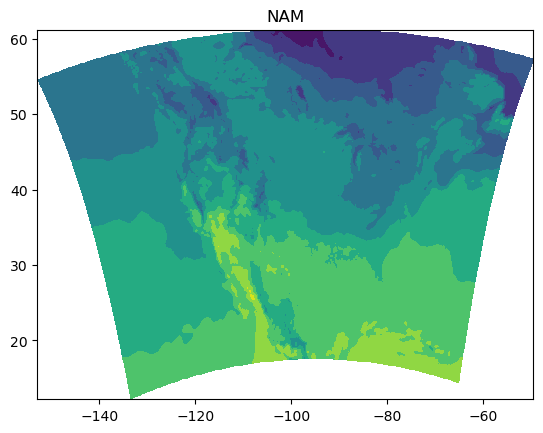

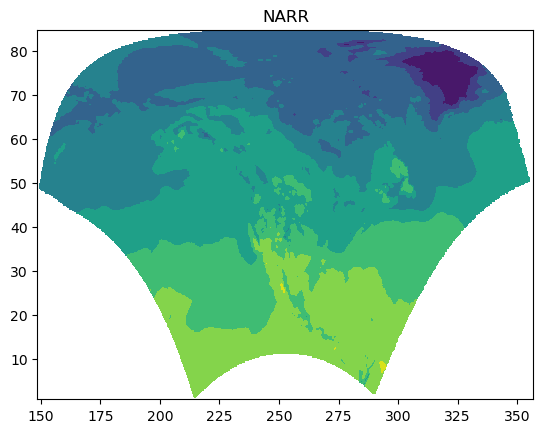

In [42]:
new_grids = {}

for m in model_options:
    mg = xr.open_dataset(f'model_regridding/output_ex/{m}_year_test_regrid.nc')

    vars = list(mg.variables)
    #print(vars)

    if m == 'CONUS404':
        mg = mg.rename({'Time': 'time'}) 
    
    new_grids[m] = mg
    plt.contourf(mg[vars[0]], mg[vars[1]], mg[vars[-1]].isel(time = 137))
    plt.title(m)
    plt.show()
    

In [1]:
def generate_plot(ds, m, extent):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,10), constrained_layout=True)   

    ax.set_extent(extent, crs = ccrs.PlateCarree())                                                                   # Set the extent according to above;; we love a good Great Lake
    ax.add_feature(cf.STATES, linewidth=1.5, edgecolor='black', alpha = 0.3)                                          # Add state boundaries 
    ax.coastlines(zorder = 10, linewidths = 1.5, color='black', alpha = 0.5)                                          # Add coastlines
    
    gl = ax.gridlines(color = 'lightgrey', draw_labels=True, linewidths = 1.5, x_inline=False, y_inline=False)        # Add the gridlines and the lat/lon labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'rotation': 0}
    gl.ylabel_style = {'size': 14, 'rotation': 0}
    gl.ylocator = mticker.FixedLocator(np.arange(10, 80, 10))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,40, 20))
    gl.top_labels    = False
    gl.right_labels  = False
    gl.left_labels   = True
    gl.bottom_labels = True


    vars = list(ds.variables)
    
    ax.pcolormesh(ds[vars[0]], ds[vars[1]], ds[vars[-1]].isel(time = 101), transform = ccrs.PlateCarree(), cmap = 'viridis', zorder=1, vmin = 225, vmax = 295)
    plt.title(m)
    plt.show()

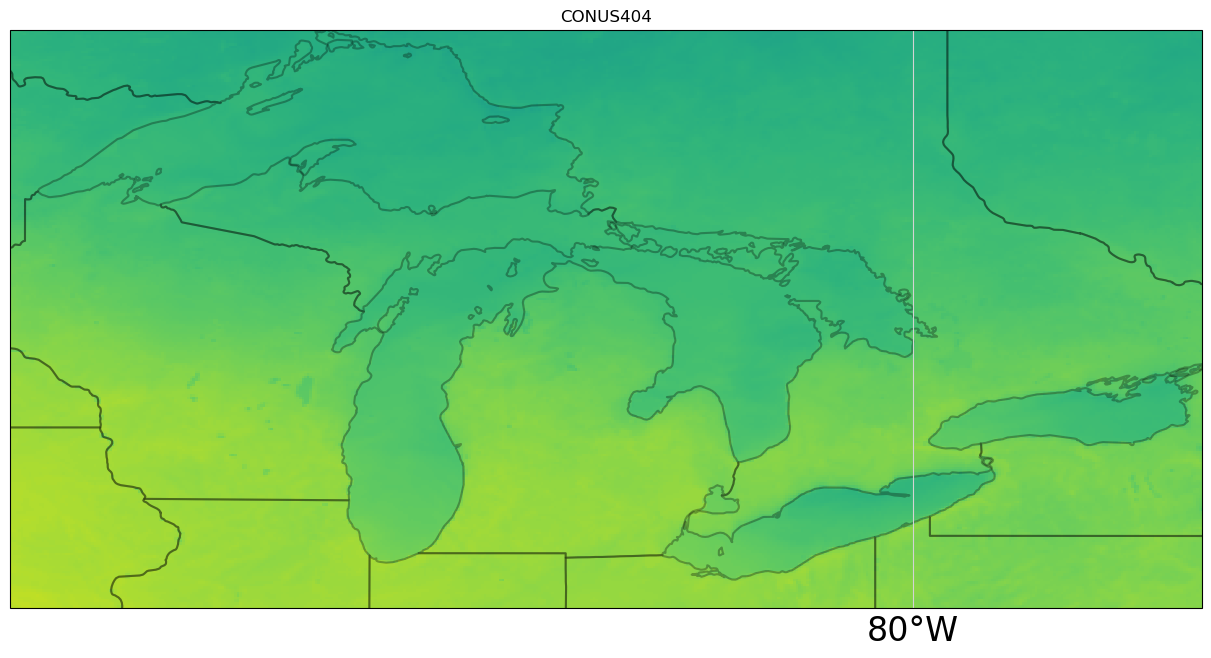

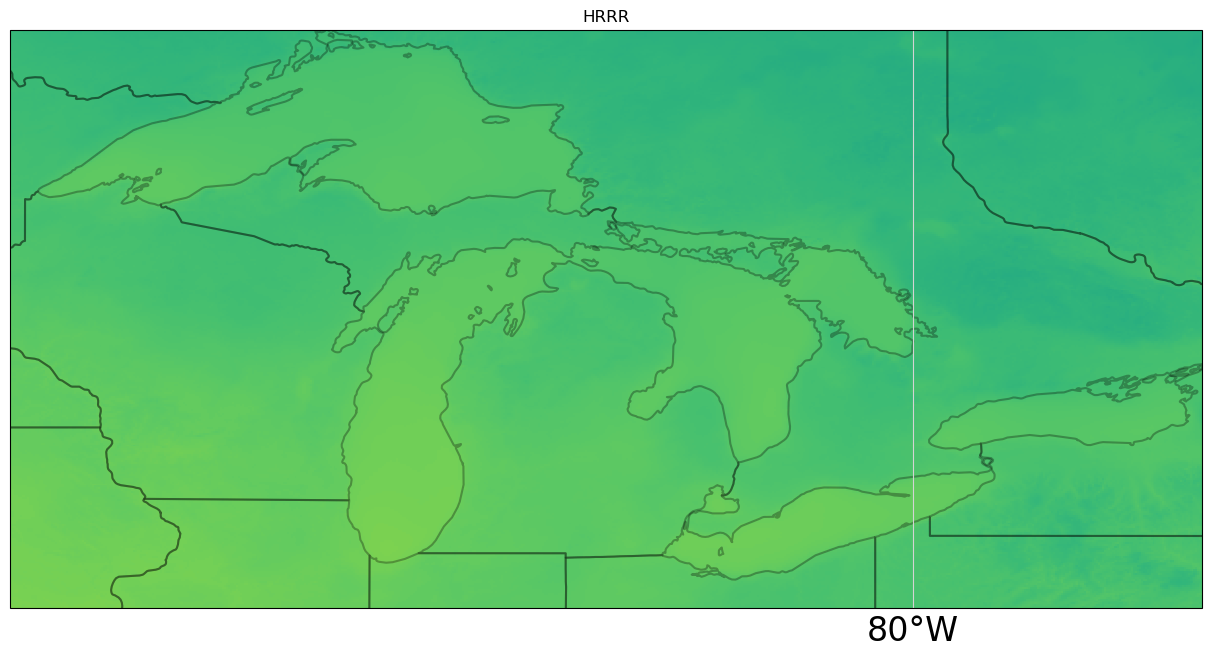

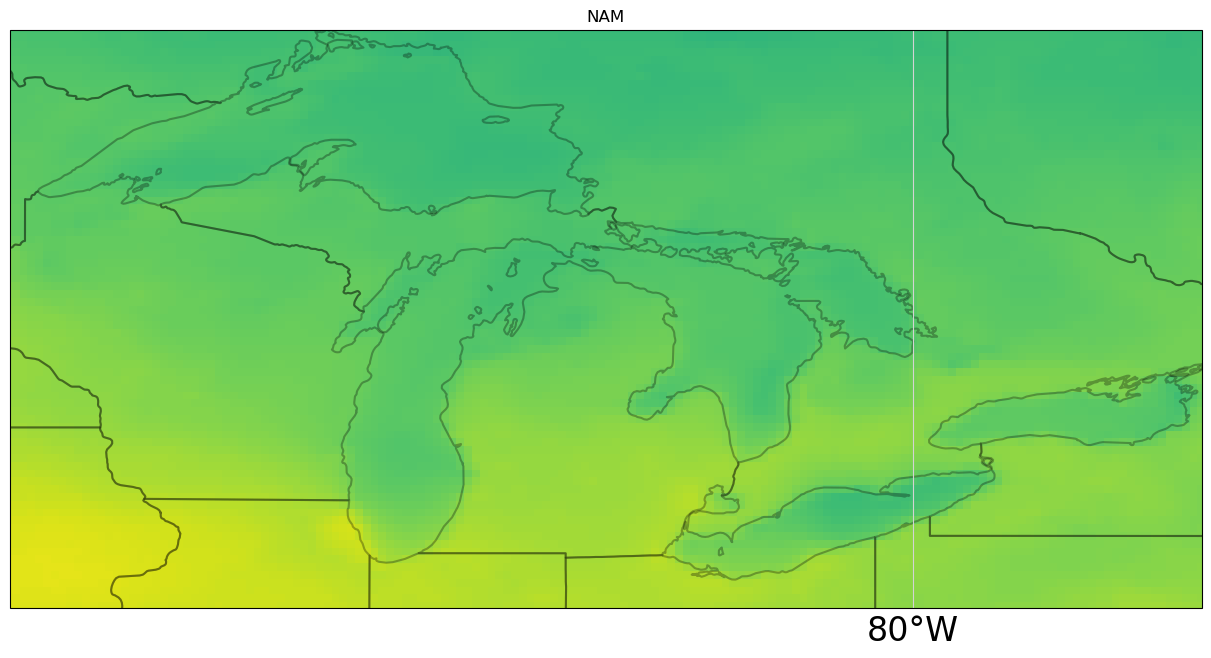

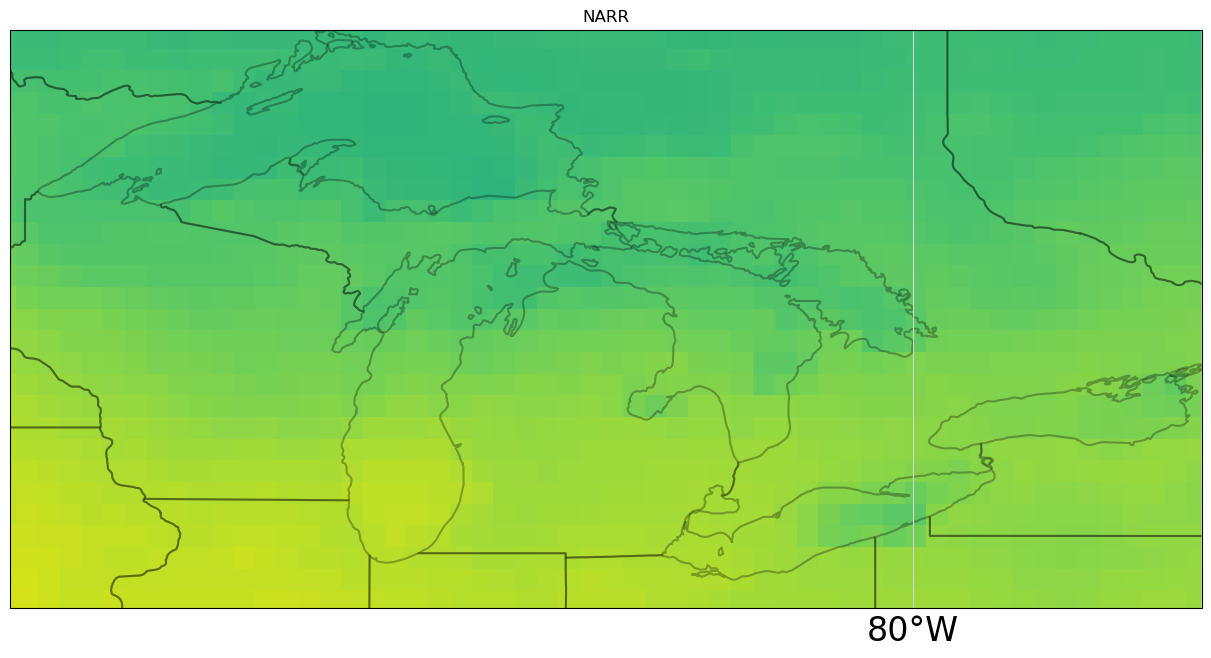

In [66]:
for m in model_options:
    generate_plot(new_grids[m],m, [-92.5, -76, 41, 49])

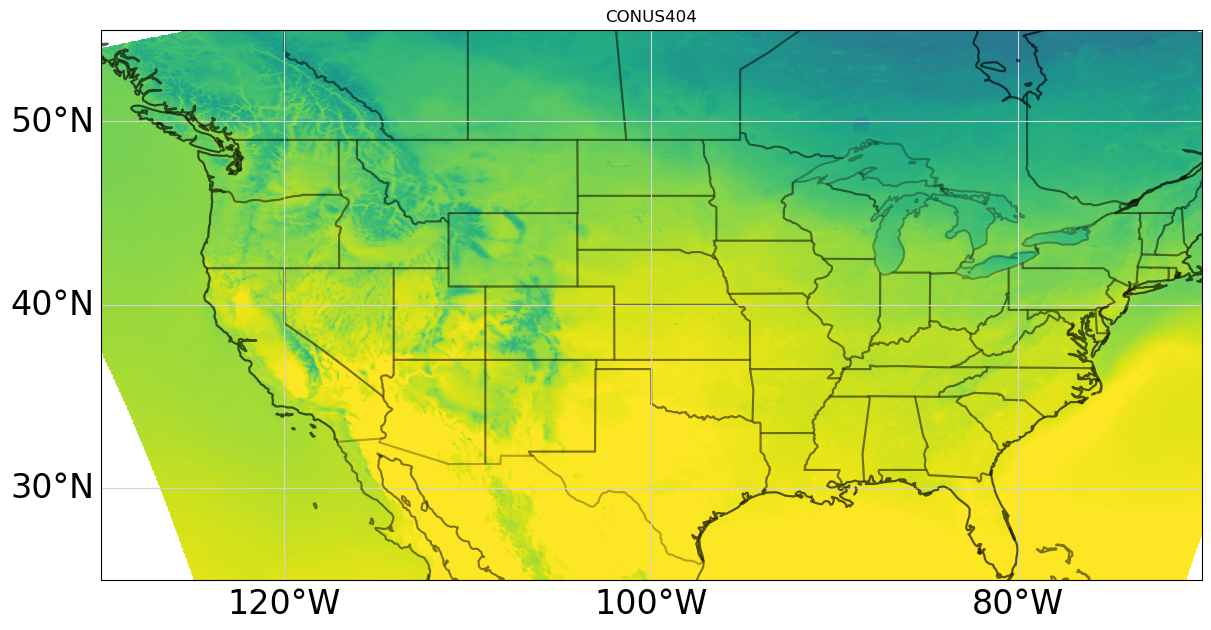

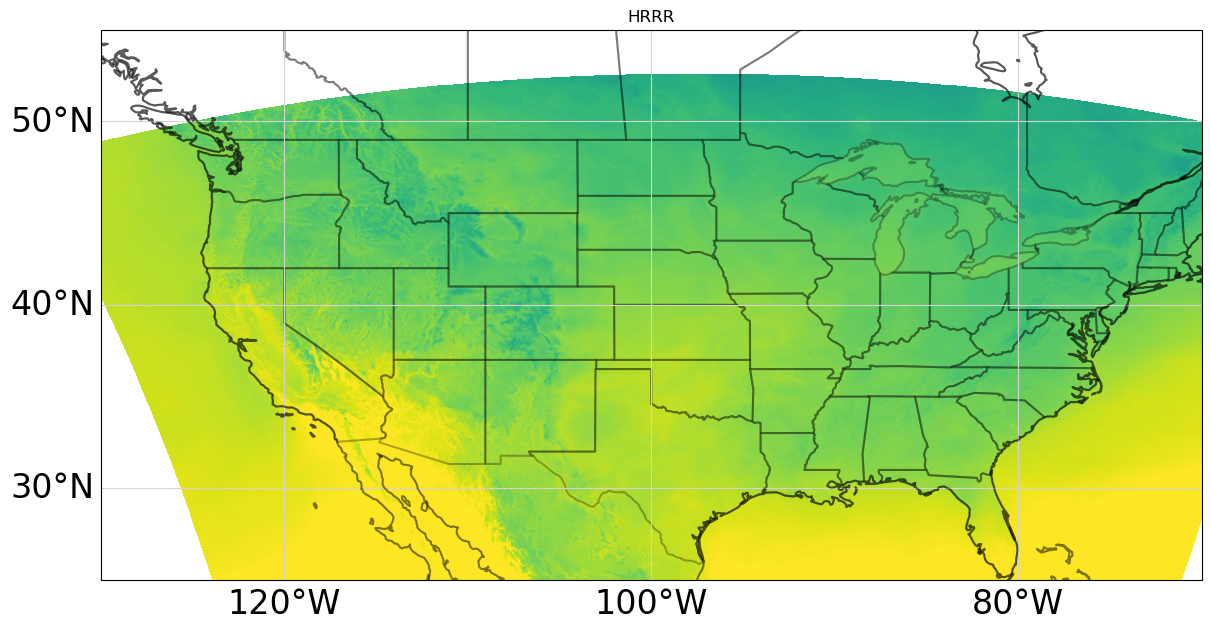

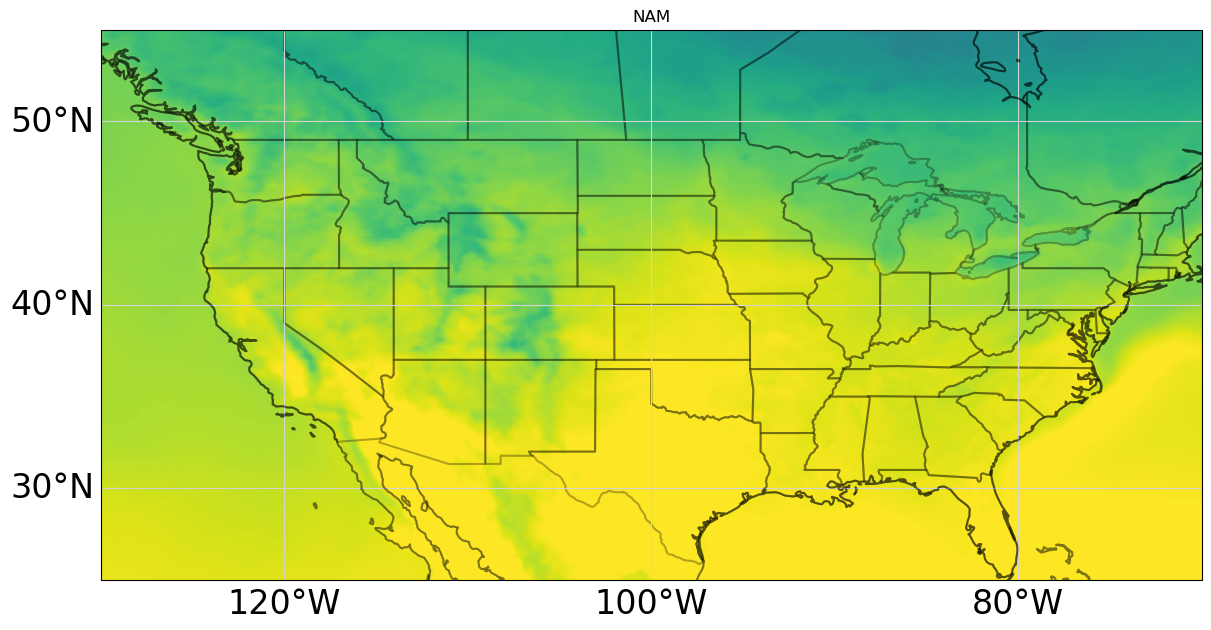

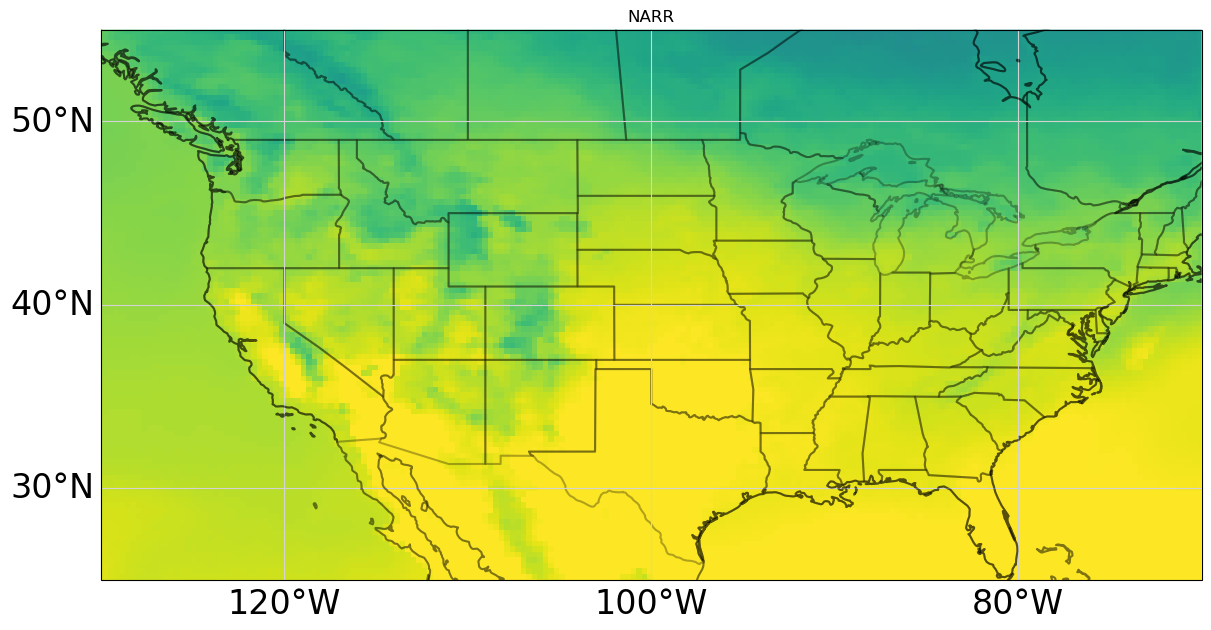

In [64]:
for m in model_options:
    generate_plot(new_grids[m],m, [-130, -70, 25, 55])

#### Test alaska/HI for NARR

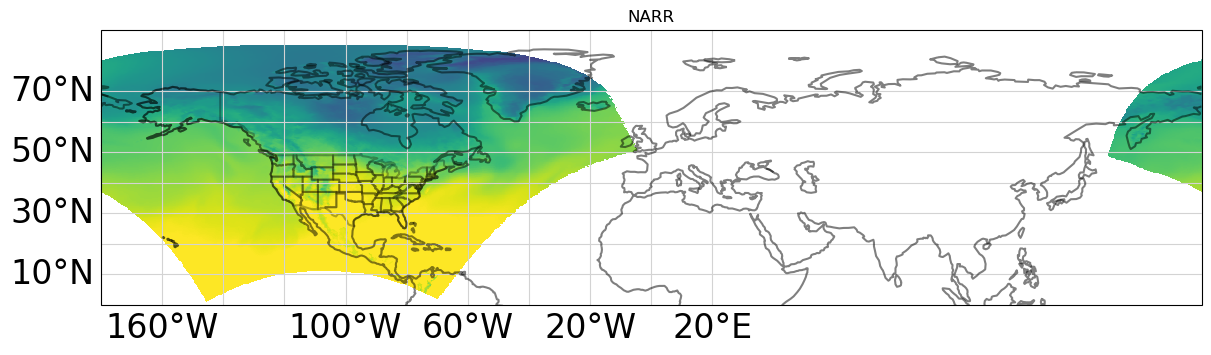

In [65]:
m = 'NARR'
generate_plot(new_grids[m],m,[-200, -1, 0, 90])

In [31]:
# woo, looks great !!!!!!

# Now loop through all files!

## First, fix problem files in the database

### NARR

###### add grid specs so that the generic grid is accepted by CDO 

In [3]:
def narr_layer_sel(v, df):

    ''' Takes input NARR files and selects the appropriate level desired 

    Inputs:

    v: (str) variable name
    df: (xarray dataset) a NARR file opened with xarray in need of level selection

    Outputs:

    df: (xarray dataset) the input df with layer selection

    '''
    try:

        if v == 'Temperature_height_above_ground':
    
            df = df.sel(height_above_ground = 2.0)
    
        elif v == 'Relative_humidity_height_above_ground':
    
            df = df.sel(height_above_ground1 = 2.0)
    
        elif v == 'Soil_moisture_content_layer_between_two_depths_below_surface_layer':
    
            df = df.isel(layer_between_two_depths_below_surface_layer = 0)
    
        elif v == 'v-component_of_wind_height_above_ground' or v == 'u-component_of_wind_height_above_ground' or v == 'wspeed' or v == 'wdir' or v == 'hdwi':
    
            df = df.sel(height_above_ground2 = 10.0)
    
        elif v == 'ffwi':
    
            df = df.sel(height_above_ground1 = 2.0, height_above_ground = 2.0, height_above_ground2 = 10)
    
        else:
    
            pass

        return df

    except:
        
        print(f'no sel for {v}')

        return df
    
    

In [5]:
def special_narr_handler_cdo(file, v, random_psl_landing_page_file_with_grid_info):

    ''' This function assigns grid information to NARR files downloaded through this code repo. For whatever reason,
    the downloaded files did not contain grid information (or it was lost in the processing steps) that is accepted by CDO.
    The bandaid fix/work around is to download a file from the PSL landing page: https://psl.noaa.gov/data/gridded/data.narr.html 
    such as air.sfc.1992.nc and use it as the bones of the xarray dataset. The time dimension is replaced with the input file, 
    the original variable is dropped, and the input dataset is changed to a new dataarray and assigned to the xarray shell. 
    This is by no means a pretty fix, but is better than going through the entire download/cleaning process prior to this step. 
    If this is not run, CDO does not recognize the 'generic grid'. 

    Inputs:

    t: (xarray dataset) a NARR file opened with xarray in need of grid assignment 
    v: (str) variable name 
    random_psl_landing_page_file_with_grid_info: (path, file) dataset manually downloaded from https://psl.noaa.gov/data/gridded/data.narr.html that contains grid information.
                                                  Ridiculously named to highlight the fact that you need this file or file like it in order for CDO to accept the NARR grid. 
                        
    Outputs:

    narr_grid: (xarray dataset) the input, t, but with grid information accepted by CDO.

    '''

    narr_grid = xr.open_dataset(random_psl_landing_page_file_with_grid_info)       # Open a dataset that contains grid information for NARR
    
    narr_grid = narr_grid.drop('air')
    
    df = xr.open_dataset(file)                                                     # Open the dataset file
    df = narr_layer_sel(v, df)                                                     # Select the appropriate layer from the dataset based on variable v
    narr_grid['time'] = df['time'] 

    try: 
        # Create a DataArray from the variable values in df, with dimensions and coordinates aligned with narr_grid
        df_vals_da = xr.DataArray(df[v].values, dims=['time', 'y', 'x'], coords={'lat': narr_grid['lat'], 'lon': narr_grid['lon'], 'y': narr_grid['y'], 'x': narr_grid['x'], 'time': narr_grid['time']})

    except KeyError:

        # try:

        var_str = f'{v}_anoms'
        
        df_vals_da = xr.DataArray(df[var_str].values, dims=['time', 'y', 'x'], coords={'lat': narr_grid['lat'], 'lon': narr_grid['lon'], 'y': narr_grid['y'], 'x': narr_grid['x'], 'time': narr_grid['time']})        
    
    narr_grid[v] = df_vals_da                                                             # Assign the newly created DataArray to narr_grid under the variable v
    
    return narr_grid

In [ ]:
### generate list of variables

vars = os.listdir('../../NARR')
vars.append('vpd')
vars.append('wspeed')
vars.append('wdir')
vars.append('hdwi')
vars.append('ffwi')
#vars

vars_dict = {}

for v in vars:

    vars_dict[v.split('_')[0]] = v

In [ ]:
input_dir = 'database_files/NARR_ungrid'                                            # Define the input directory for ungridded NARR files
    
for f in os.listdir(input_dir):                                                     # Iterate over files in the input directory
    if f[-2:] == 'nc':                                                              # Check if the file is a NetCDF file
        
        file = f'{input_dir}/{f}'                                                   # Construct the full file path
    
        try:      
            v = vars_dict[file.split('/')[-1].split('_')[0]]                        # Attempt to extract the variable name from the file name
        
        except KeyError:      
            v = vars_dict[file.split('/')[-1].split('_')[0][0:-3]]                  # Adjust the variable extraction for special cases
            
        out_narr = special_narr_handler_cdo(file, v, 'Regridding/air.sfc.1992.nc')  # Call a special handler function for NARR data regridding
        
        coords_to_keep = ['time', 'lat', 'lon', 'y', 'x']                           # Define the coordinates to keep
        out_narr_coords = list(out_narr.coords)                                     # List all coordinates in the output dataset
              
        if len(coords_to_keep) != len(out_narr_coords):                             # Check if there are extra coordinates
            delete = [i for i in out_narr_coords if i not in coords_to_keep]        # Identify coordinates to delete
            out_narr = out_narr.drop(delete)                                        # Drop unwanted coordinates
      
        out_narr.to_netcdf(f'database_files/NARR/{f}')                              # Save the regridded dataset to a NetCDF file
              

### For Anoms

In [9]:
### generate list of variables

vars = os.listdir('../database_files/NARR_ungrid/Anoms/')


# vars.append('vpd')
# vars.append('wspeed')
# vars.append('wdir')
# vars.append('hdwi')
# vars.append('ffwi')
# #vars



In [116]:
vars = ['ffwi', 'hdwi', 'Planetary_boundary_layer_height_surface',
        'Precipitation_rate_surface', 'Relative_humidity_height_above_ground',
        'Soil_moisture_content_layer_between_two_depths_below_surface_layer',
        'Temperature_height_above_ground', 
        'Total_precipitation_surface_3_Hour_Accumulation',
        'u-component_of_wind_height_above_ground',
        'v-component_of_wind_height_above_ground',
        'vpd', 'wdir', 'wspeed']


In [117]:
vars_dict = {}

for v in vars:

    vars_dict[v.split('_')[0]] = v

In [131]:
input_dir = '../database_files/NARR_ungrid/Climos'                                            # Define the input directory for ungridded NARR files
    
for f in os.listdir(input_dir):                                                     # Iterate over files in the input directory
    if f[-2:] == 'nc':                                                              # Check if the file is a NetCDF file
        
        file = f'{input_dir}/{f}'                                                   # Construct the full file path
    
        try:      
            v = vars_dict[file.split('/')[-1].split('_')[0]]                        # Attempt to extract the variable name from the file name
        
        except KeyError:      
            v = vars_dict[file.split('/')[-1].split('_')[0][0:-3]]                  # Adjust the variable extraction for special cases
            
        out_narr = special_narr_handler_cdo(file, v, 'air.sfc.1992.nc')  # Call a special handler function for NARR data regridding
        
        coords_to_keep = ['time', 'lat', 'lon', 'y', 'x']                           # Define the coordinates to keep
        out_narr_coords = list(out_narr.coords)                                     # List all coordinates in the output dataset
              
        if len(coords_to_keep) != len(out_narr_coords):                             # Check if there are extra coordinates
            delete = [i for i in out_narr_coords if i not in coords_to_keep]        # Identify coordinates to delete
            out_narr = out_narr.drop(delete)                                        # Drop unwanted coordinates
      
        out_narr.to_netcdf(f'../database_files/NARR/Climos/{f}')                              # Save the regridded dataset to a NetCDF file
        print(f)  

/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


no sel for ffwi
ffwi_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for hdwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


hdwi_NARR_REANALYSIS_Abs_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Planetary_boundary_layer_height_surface_NARR_REANALYSIS_Abs_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Precipitation_rate_surface_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for Relative_humidity_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Relative_humidity_height_above_ground_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for Soil_moisture_content_layer_between_two_depths_below_surface_layer


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Soil_moisture_content_layer_between_two_depths_below_surface_layer_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for Temperature_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Temperature_height_above_ground_NARR_REANALYSIS_Abs_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Total_precipitation_surface_3_Hour_Accumulation_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for u-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


u-component_of_wind_height_above_ground_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for v-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


v-component_of_wind_height_above_ground_NARR_REANALYSIS_Abs_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


vpd_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for wdir


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wdir_NARR_REANALYSIS_Abs_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


no sel for wspeed


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wspeed_NARR_REANALYSIS_Abs_climos_full_period.nc
no sel for ffwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


ffwi_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for hdwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


hdwi_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Planetary_boundary_layer_height_surface_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Precipitation_rate_surface_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Relative_humidity_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Relative_humidity_height_above_ground_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Soil_moisture_content_layer_between_two_depths_below_surface_layer


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Soil_moisture_content_layer_between_two_depths_below_surface_layer_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Temperature_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Temperature_height_above_ground_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Total_precipitation_surface_3_Hour_Accumulation_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for u-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


u-component_of_wind_height_above_ground_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


no sel for v-component_of_wind_height_above_ground
v-component_of_wind_height_above_ground_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


vpd_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for wdir


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wdir_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


no sel for wspeed


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wspeed_AVG_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for ffwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


ffwi_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for hdwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


hdwi_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Planetary_boundary_layer_height_surface_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Precipitation_rate_surface_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Relative_humidity_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Relative_humidity_height_above_ground_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Soil_moisture_content_layer_between_two_depths_below_surface_layer


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Soil_moisture_content_layer_between_two_depths_below_surface_layer_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Temperature_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Temperature_height_above_ground_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Total_precipitation_surface_3_Hour_Accumulation_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for u-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


u-component_of_wind_height_above_ground_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for v-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


v-component_of_wind_height_above_ground_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


vpd_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for wdir


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wdir_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for wspeed


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wspeed_MIN_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for ffwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


ffwi_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for hdwi


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


hdwi_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Planetary_boundary_layer_height_surface_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Precipitation_rate_surface_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Relative_humidity_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Relative_humidity_height_above_ground_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Soil_moisture_content_layer_between_two_depths_below_surface_layer


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Soil_moisture_content_layer_between_two_depths_below_surface_layer_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for Temperature_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Temperature_height_above_ground_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Total_precipitation_surface_3_Hour_Accumulation_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for u-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


u-component_of_wind_height_above_ground_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for v-component_of_wind_height_above_ground


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


v-component_of_wind_height_above_ground_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


vpd_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc
no sel for wdir


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wdir_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


no sel for wspeed


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


wspeed_MAX_NARR_REANALYSIS_Daily_climos_full_period.nc


# bash script for terminal to loop over all files. 

in the terminal:

    vi name_of_sh_file.sh

        paste the text in
        adjust the path names accordingly
        press :wq to save the file

    chmod +x name_of_sh_file.sh
    ./name_of_sh_file.sh

and your loop will be off! 

# use the Regrid_Check_n_Clean.ipynb to see if files were successful or some bandaid work needs done